In [1]:
import wfdb
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt 

In [2]:
labels_set = ('N','S','V','F','Q')
labels_dict = {'N':0,'S':1,'V':2,'F':3,'Q':4}

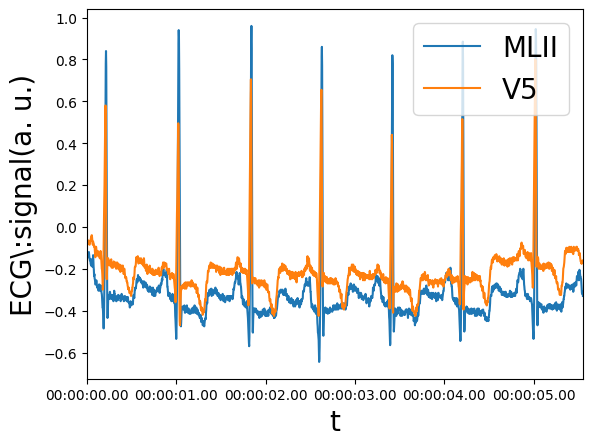

In [3]:
base_fld = './'
data_fld = "C:/Users/kalyani/Documents/Intern_summer_2024/mitdb/mit-bih-arrhythmia-database-1.0.0/"
record = wfdb.rdrecord(data_fld+'/100', sampto=2000)
df = record.to_dataframe()
df.plot()
plt.xlabel('t',fontsize=20)
plt.ylabel('ECG\:signal(a. u.)',fontsize=20)
plt.legend(fontsize=20, loc=1)
plt.savefig('data_1.png')

In [4]:
def get_normal_beat_labels():
    """
    The MIT-BIH labels that are classified as healthy/normal. Check wfdb.Annotation documentation for description of labels.
    N: {N, L, R, e, j}. 
    """
    return np.array(["N", "L", "R", "e", "j"])

def get_abnormal_beat_labels():
    """
    The MIT-BIH labels that are classified as arrhythmia/abnormal. Check wfdb.Annotation documentation for description of labels.
    S: {S, A, J, a} - V: {V, E} - F: {F} - Q: {Q}
    """
    return np.array(["S", "A", "J", "a", "V", "E", "F", "Q"])

def get_beat_class(label):
    """
    A mapping from labels to classes, based on the rules described in get_normal_beat_labels() and get_abnormal_beat_labels().
    """
    if label in ["N", "L", "R", "e", "j"]:
        return "N"
    elif label in ["S", "A", "J", "a"]:
        return "S"
    elif label in ["V", "E"]:
        return "V"
    elif label == "F" or label == "Q":
        return label
    return None

In [5]:
class arrhythmia:
    def __init__(self, data_path):
        self.path = data_path
        self.record = wfdb.rdrecord(data_path)
        self.annotation = wfdb.rdann(data_path, extension='atr')
        self.time = None
        self.time_series = None
        self.R_idx = None
        
        self.pulse_arr = None
        self.lable_arr = None
        
    def get_pulse_with_label(self):
        
        data_path = self.path
        
        # Extract time series
        record = self.record
        df = record.to_dataframe()
        try:
            time_series = np.array(df['MLII'])
        except:
            time_series = np.array(df['V5'])
            

        # Extract peak index and labels

        annotation = self.annotation
        idx_arr = annotation.sample                              # idx denotes the peak location known as R based on PQRST convension
        sym_arr = np.array(annotation.symbol)                    # Gives the raw labes
        lab_arr = np.array([get_beat_class(s) for s in sym_arr]) # Labels are assigned from {N,S,V,F,Q}

        # Split 
        pulse_arr = []
        pulse_lab = []
        R_idx  = []

        labels_set = ('N','S','V','F','Q')

        for i in range(len(idx_arr)):
            if (lab_arr[i] in labels_set) and ((idx_arr[i]-130)>0) and ((idx_arr[i]+130)<len(time_series)): 

                pulse_arr.append(time_series[(idx_arr[i]-130):(idx_arr[i]+130)])
                pulse_lab.append(lab_arr[i])
                R_idx.append(idx_arr[i])
                
        self.time = np.arange(len(time_series))*record.fs
        self.time_series = time_series
        self.R_idx = np.array(R_idx)
        
        self.pulse_arr = np.array(pulse_arr)
        self.lable_arr = np.array(pulse_lab) 
        
    def plot_pulse(self, axs, idx):
        axs.plot(self.pulse_arr[idx])
        axs.set_title(self.lable_arr[idx])
        
    def __repr__(self):
        return "Data from subject '"+self.record.record_name+"'"

In [6]:
def get_all_heart_beats(data_all):
    keys = list(data_all.keys())
    
    pulse_seg = data_all[keys[0]].pulse_arr
    pulse_lab = data_all[keys[0]].lable_arr
     
    #print(pulse_seg.shape)
    
    for key in keys[1::]:
        #print(data_all[key].pulse_arr.shape)
        pulse_seg = np.vstack([pulse_seg, data_all[key].pulse_arr])
        pulse_lab = np.hstack((pulse_lab, data_all[key].lable_arr))
    return pulse_seg, pulse_lab

In [7]:
def get_z_normalized(pulses):
    print(pulses.shape)
    mu = np.mean(pulses, axis=1).reshape(-1,1)
    std = np.std(pulses, axis=1).reshape(-1,1)
    pulses_normed = (pulses-mu)/std
    
    return pulses_normed

In [9]:
file_names = np.loadtxt(data_fld+'/Records',dtype=str)
file_names

array(['100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '121', '122', '123', '124', '200', '201', '202', '203',
       '205', '207', '208', '209', '210', '212', '213', '214', '215',
       '217', '219', '220', '221', '222', '223', '228', '230', '231',
       '232', '233', '234'], dtype='<U3')

In [10]:
data_all = {}
for file in file_names:
    data_obj = arrhythmia(data_fld+'/'+file)
    data_obj.get_pulse_with_label()
    data_all[str(file)] = data_obj

In [11]:
pulse_all, labels_all = get_all_heart_beats(data_all)

In [12]:
for l in labels_set:
    print("Number of beats in class ",l,':',sum(labels_all==l))

Number of beats in class  N : 90593
Number of beats in class  S : 2781
Number of beats in class  V : 7235
Number of beats in class  F : 802
Number of beats in class  Q : 33


Balancing for  N
Balancing for  S
Balancing for  V
Balancing for  F
Balancing for  Q


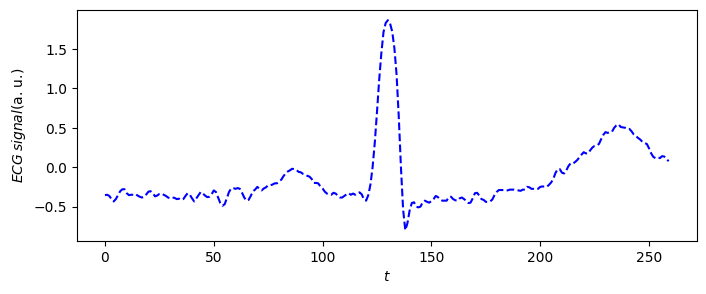

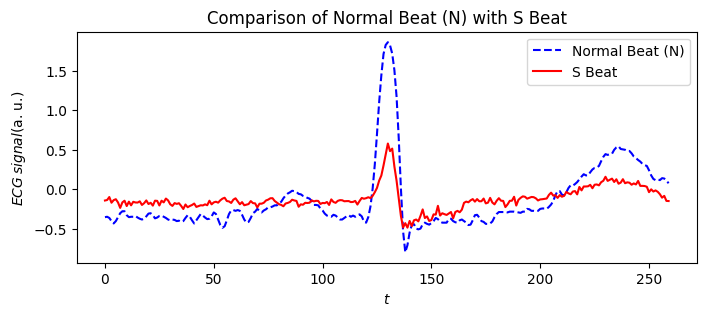

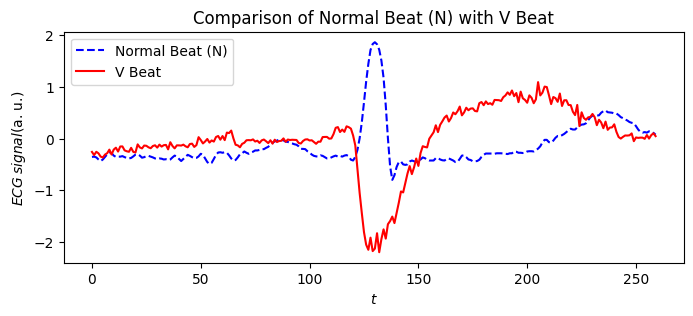

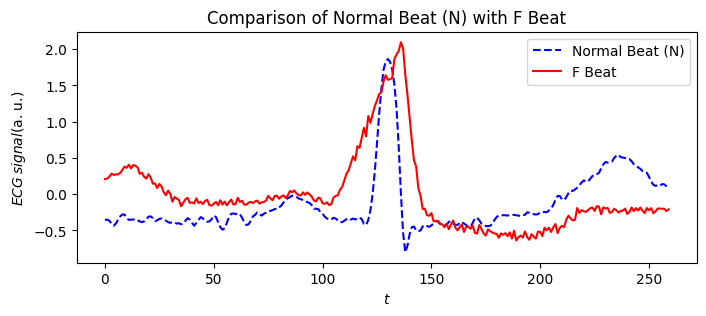

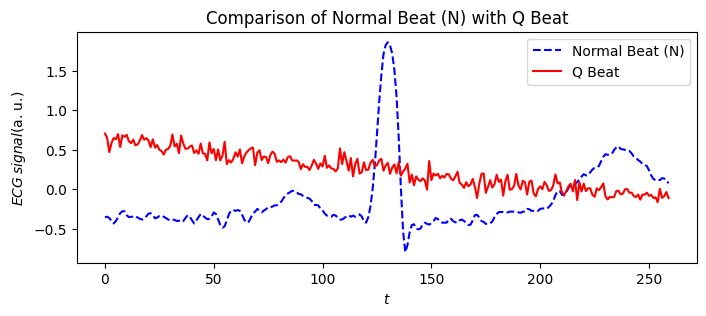

In [51]:

# Function to balance the data
def get_balanced_data(pulses, labels):
    seg_len = pulses.shape[1]
    number_of_beats = [sum(labels == l) for l in labels_set]
    number_of_beats = np.array(number_of_beats)
    max_num_of_beats = max(number_of_beats)
    required_num_of_beats = max_num_of_beats - number_of_beats

    pulses_aug = pulses.copy()
    labels_aug = labels.copy()

    for i in range(len(labels_set)):
        print("Balancing for ", labels_set[i])

        n = required_num_of_beats[i]

        pulses_sel = pulses[labels == labels_set[i]]
        pulse_mean = np.mean(pulses_sel, axis=0)
        pulse_std = np.std(pulses_sel, axis=0)

        id_sel = np.random.randint(number_of_beats[i], size=n)
        pulses_sel = pulses_sel[id_sel, :]

        noise_level = pulse_std * 0.1
        noise = np.random.normal(0, 1, (n, seg_len)) * noise_level

        pulse_temp = pulses_sel + noise
        pulses_aug = np.vstack([pulses_aug, pulse_temp])

        labels_temp = np.array([labels_set[i]] * n)
        labels_aug = np.hstack([labels_aug, labels_temp])

        #fig = plt.figure(figsize=(8, 1))
        #axs = fig.add_subplot(1, 1, 1)
        #if n > 0:
         #   axs.plot(pulses_sel[0, :], label='Sample real')
        #axs.plot(pulses_aug[-1, :], label='Sample augmented')

        #axs.set_title(labels_set[i], fontsize=10)
        #plt.xlabel('$t$', fontsize=10)
        #plt.ylabel('$ECG\:signal$(a. u.)', fontsize=10)
        #plt.legend(fontsize=10, loc=1)

    return pulses_aug, labels_aug



# Function to plot one random beat from each type and superimpose the normal beat
def plot_heartbeat_comparisons(pulses, labels):
    normal_pulses = pulses[labels == 'N']
    random_normal_beat = normal_pulses[np.random.randint(len(normal_pulses))]
    plt.figure(figsize=(8,3))
    plt.plot(random_normal_beat, label='Normal Beat (N)', linestyle='--', color='blue')
    plt.xlabel('$t$')
    plt.ylabel('$ECG\:signal$(a. u.)')
    
    for label in labels_set:
        if label != 'N':
            plt.figure(figsize=(8, 3))
            
            # Plot one random normal beat
            #random_normal_beat = normal_pulses[np.random.randint(len(normal_pulses))]
            plt.plot(random_normal_beat, label='Normal Beat (N)', linestyle='--', color='blue')
            
            # Plot one random beat of the other type
            other_pulses = pulses[labels == label]
            random_other_beat = other_pulses[np.random.randint(len(other_pulses))]
            plt.plot(random_other_beat, label=f'{label} Beat', color='red')
            
            plt.title(f'Comparison of Normal Beat (N) with {label} Beat')
            plt.xlabel('$t$')
            plt.ylabel('$ECG\:signal$(a. u.)')
            plt.legend()
            plt.show()

# Example usage
# Assuming you have pulses and labels already loaded
# pulses, labels = load_your_data_here()

# Balance the data
balanced_pulses, balanced_labels = get_balanced_data(pulse_all, labels_all)

# Plot comparisons
plot_heartbeat_comparisons(balanced_pulses, balanced_labels)


In [13]:
pulses_normed = get_z_normalized(pulse_all)

(101444, 260)


In [25]:
# Plot comparisons
#plot_heartbeat_comparisons(pulse_all, labels_all)

Balancing for  N
Balancing for  S
Balancing for  V
Balancing for  F
Balancing for  Q


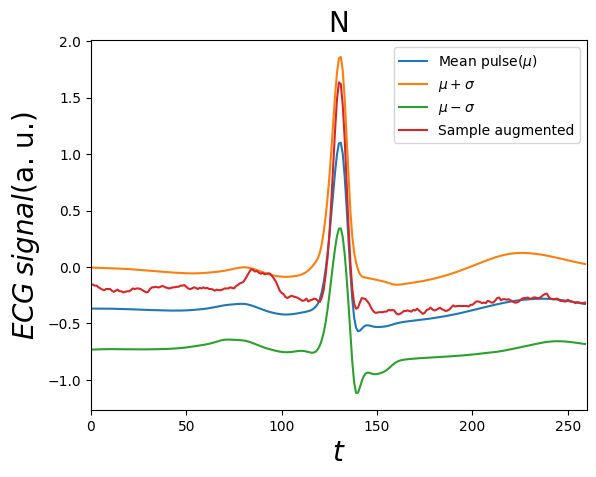

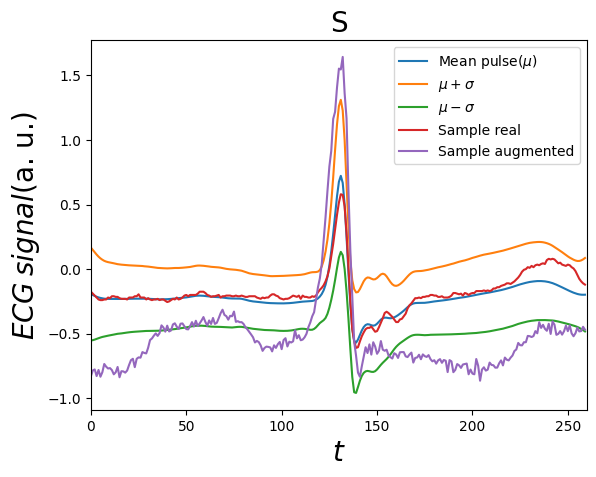

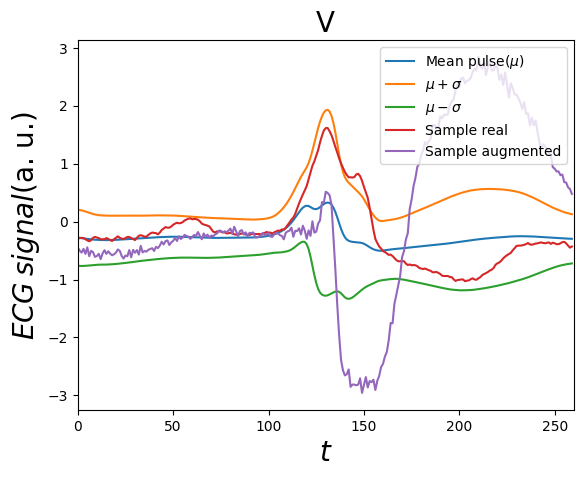

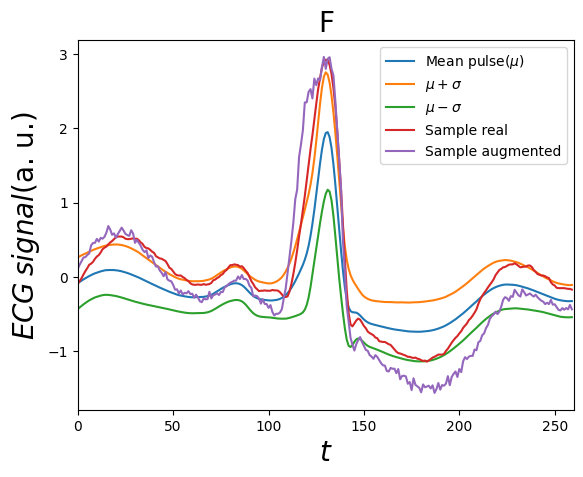

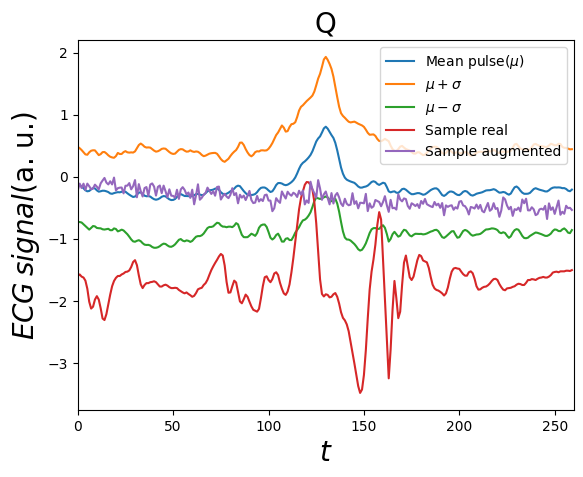

In [14]:
pulses_bal, labels_bal = get_balanced_data(pulse_all, labels_all)